Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [67]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [68]:
# Defining the path for train and test images

data_dir_train = pathlib.Path('CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train')
data_dir_test = pathlib.Path('CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [69]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [70]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

### Image Pre-processing

In [71]:
## Image Pre-processing to format images before they are used for the model training and inference

#pre-processing training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            labels = 'inferred',
            batch_size = batch_size,
            subset = 'training',
            image_size = (img_height,img_width),
            seed=123,
            validation_split = 0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [72]:
#pre-processing validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            labels = 'inferred',
            batch_size = batch_size,
            subset = 'validation',
            image_size = (img_height,img_width),
            seed=123,
            validation_split = 0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [73]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualizing one instance of all the training classes present in the dataset

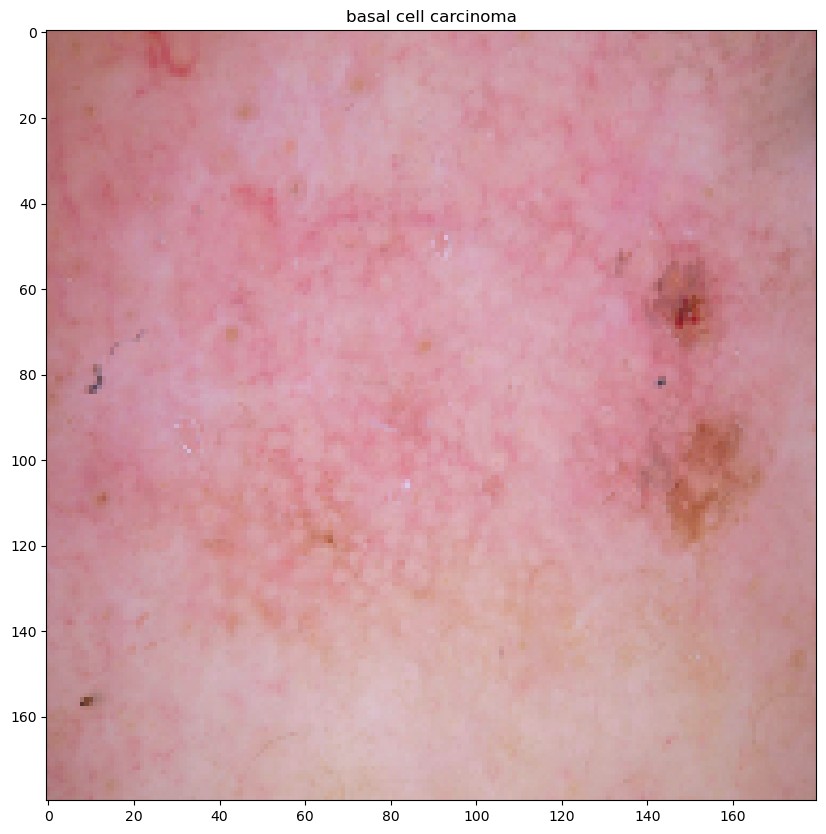

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    plt.imshow(images[1].numpy().astype("uint8"))
    plt.title(class_names[1])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [75]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [76]:
num_classes = 9
model = Sequential(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [77]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
# View the summary of all layers
model.build(input_shape=(img_height,img_width,3))

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_47 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 batch_normalization_32 (Ba  (None, 180, 180, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_33 (Conv2D)          (None, 178, 178, 32)      4640      
                                                                 
 activation_48 (Activation)  (None, 178, 178, 32)      0         
                                                     

### Train the model

In [79]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 44s 723ms/step - loss: 3.4161 - accuracy: 0.2349 - val_loss: 5.1419 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 41s 738ms/step - loss: 2.0155 - accuracy: 0.2952 - val_loss: 14.4335 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 43s 764ms/step - loss: 1.8174 - accuracy: 0.3510 - val_loss: 14.9475 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 42s 745ms/step - loss: 1.7793 - accuracy: 0.3672 - val_loss: 7.1402 - val_accuracy: 0.2237
Epoch 5/20
56/56 [==============================] - 43s 769ms/step - loss: 1.6551 - accuracy: 0.4107 - val_loss: 6.5143 - val_accuracy: 0.2908
Epoch 6/20
56/56 [==============================] - 44s 783ms/step - loss: 1.5354 - accuracy: 0.4498 - val_loss: 2.0523 - val_accuracy: 0.4295
Epoch 7/20
56/56 [==============================] - 44s 790ms/step - loss: 1.4607 - accuracy: 0.4665 - val_loss: 2.1675 - val_accuracy: 0.42

### Visualizing training results

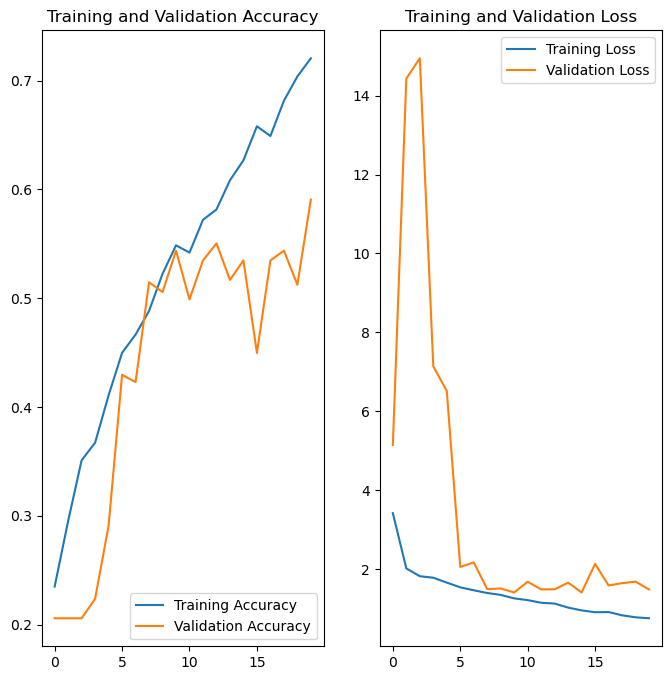

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

After 20 Epochs the Training accuracy is - 74% and validation accuracy - 58% 

Training accuracy performs better than validation accuracy and training loss gradually decreases while validation loss also decreases but there is no convergence. 

This is a case of overfitting

In [102]:
# Adding the appropriate data augmentation strategy

data_augmentation = keras.Sequential([

    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation((0,1)),
    layers.experimental.preprocessing.RandomZoom((0,1)),
    layers.experimental.preprocessing.RandomCrop(img_height, img_width),
    layers.experimental.preprocessing.RandomTranslation(1,0.5, fill_mode="reflect",interpolation= "bilinear",seed=None, fill_value=0.0),
]
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


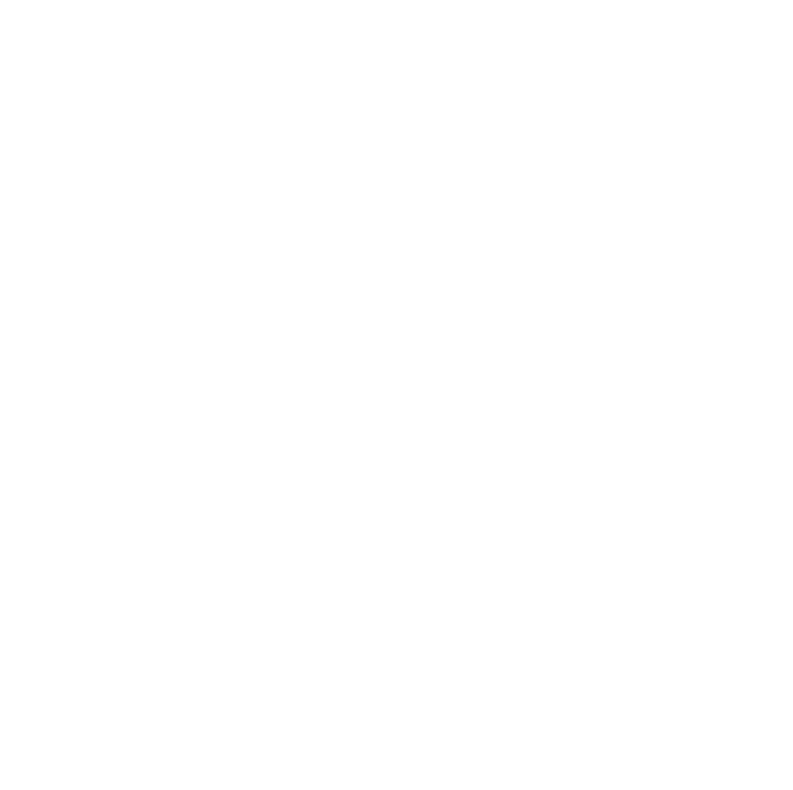

In [105]:
# visualizing the augmentation strategy works for one instance of training image.

plt.figure(figsize = (10,10))
for i in range(9):
  augmented_images = data_augmentation(images)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_images[0])
  plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [107]:
## Using Dropout layer since there is overfitting in the model findings

num_classes = 9
model = Sequential([data_augmentation, layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



### Compiling the model

In [109]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# View the summary of all layers
model.build(input_shape=(img_height,img_width,3))

print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_53 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 batch_normalization_36 (Ba  (None, 180, 180, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_37 (Conv2D)          (None, 178, 178, 32)      4640      
                                                     

### Training the model

In [110]:
## Retraining the model for the same epochs 20 after adding drop out in the model 
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 108s 2s/step - loss: 4.3593 - accuracy: 0.1881 - val_loss: 8.0246 - val_accuracy: 0.0403
Epoch 2/20
56/56 [==============================] - 113s 2s/step - loss: 2.0917 - accuracy: 0.2360 - val_loss: 7.9223 - val_accuracy: 0.1678
Epoch 3/20
56/56 [==============================] - 99s 2s/step - loss: 2.0036 - accuracy: 0.2522 - val_loss: 6.6869 - val_accuracy: 0.1141
Epoch 4/20
56/56 [==============================] - 88s 2s/step - loss: 1.9845 - accuracy: 0.2879 - val_loss: 10.7895 - val_accuracy: 0.0492
Epoch 5/20
56/56 [==============================] - 84s 2s/step - loss: 1.9508 - accuracy: 0.2930 - val_loss: 7.6959 - val_accuracy: 0.0738
Epoch 6/20
56/56 [==============================] - 83s 1s/step - loss: 1.9305 - accuracy: 0.2879 - val_loss: 4.2326 - val_accuracy: 0.1007
Epoch 7/20
56/56 [==============================] - 83s 1s/step - loss: 1.9091 - accuracy: 0.3075 - val_loss: 4.0889 - val_accuracy: 0.1946
Epoch 8/20
56/56 

### Visualizing the results

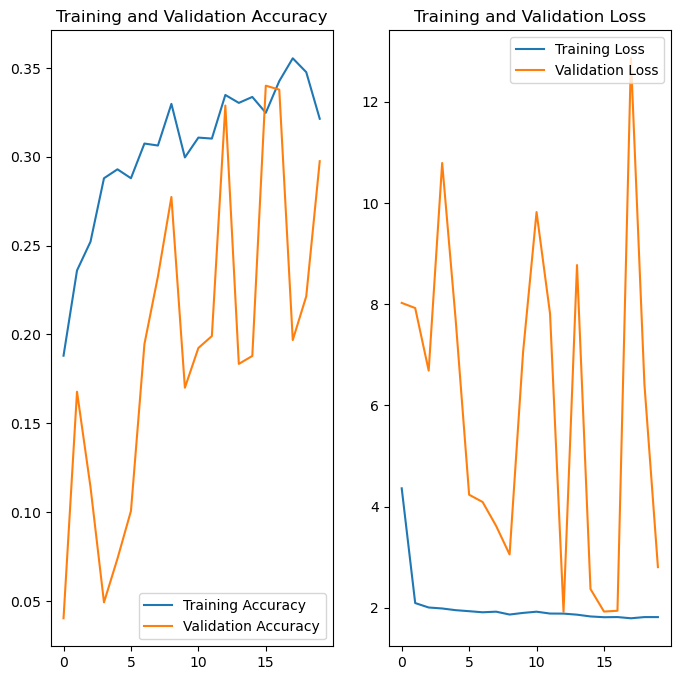

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 The model has underperformed second time and also the accuracy has dropped significantly

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

C:\Users\vp63954\AppData\Local\Temp\ipykernel_14212\743672005.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels())


[Text(-1.0, 0, '−1'),
 Text(0.0, 0, '0'),
 Text(1.0, 0, '1'),
 Text(2.0, 0, '2'),
 Text(3.0, 0, '3'),
 Text(4.0, 0, '4'),
 Text(5.0, 0, '5'),
 Text(6.0, 0, '6'),
 Text(7.0, 0, '7'),
 Text(8.0, 0, '8'),
 Text(9.0, 0, '9')]

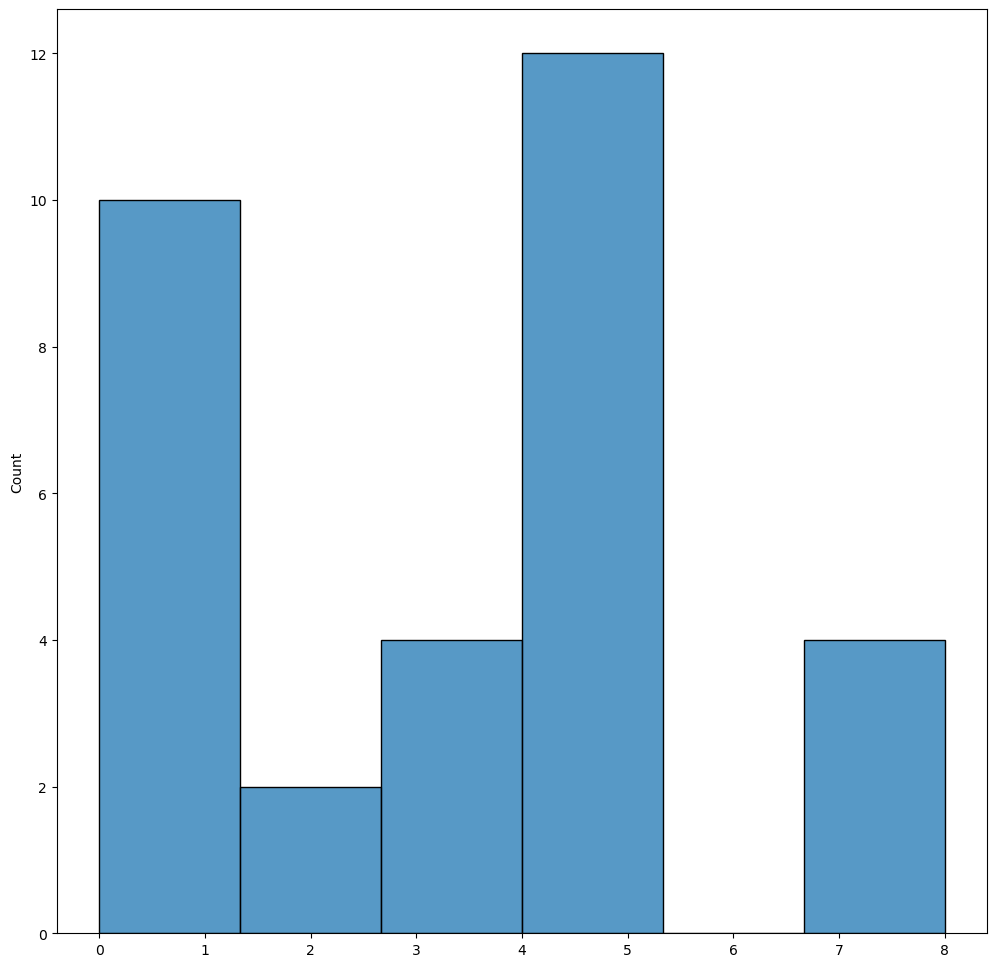

In [125]:
import seaborn as sns

plt.figure(figsize=(12,12))

plot = sns.histplot(data=labels);


plot.set_xticklabels(plot.get_xticklabels())


Class2 has least number of samples
class5 has highest samples
There is class clear imbalance for all the classes

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [122]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [136]:
path_to_training_dataset= "CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189FFCAAF50>: 100%|█| 500/500 [00:03<00:00, 152.39 Samples


Initialised with 376 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189CCB43A10>: 100%|█| 500/500 [00:03<00:00, 157.29 Samples


Initialised with 95 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x189C4D77190>: 100%|█| 500/500 [00:03<00:


Initialised with 438 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1899820E410>: 100%|█| 500/500 [00:19<00:00, 25.46 Samples


Initialised with 357 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x189CD8B0510>: 100%|█| 500/500 [00:23<00:00, 21.01 Samples


Initialised with 462 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x189CE379050>: 100%|█| 500/500 [00:05<00:


Initialised with 77 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1899A80BF50>: 100%|█| 500/500 [00:12<00


Initialised with 181 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189CCBC3D50>: 100%|█| 500/500 [00:05<00:00, 86.98 Samples/


Initialised with 139 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x189CAF7F9D0>: 100%|█| 500/500 [00:05<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [137]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [148]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_074c3f00-aa78-4bcb-8630-afd010e4d7ed.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_479433a6-5411-4e2b-af7f-1308705409dc.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_49c64976-b191-4b6b-ae51-3254f416fd36.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_85b3a177-8cc6-436b-ba2f-dce4af3a7232.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_96a4ef9c-390d-4218-a1b8-e12500492

In [149]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [150]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [158]:
#df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [159]:
#new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [160]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [161]:
data_dir_train=pathlib.Path('CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [157]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [162]:
num_classes = 9
model = Sequential([data_augmentation, layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [163]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# View the summary of all layers
model.build(input_shape=(img_height,img_width,3))

print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_59 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 batch_normalization_40 (Ba  (None, 180, 180, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_41 (Conv2D)          (None, 178, 178, 32)      4640      
                                                     

#### **Todo:**  Train your model

In [164]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 232s 1s/step - loss: 3.3714 - accuracy: 0.1408 - val_loss: 9.9168 - val_accuracy: 0.1114
Epoch 2/30
169/169 [==============================] - 171s 1s/step - loss: 2.1655 - accuracy: 0.1699 - val_loss: 9.1101 - val_accuracy: 0.1411
Epoch 3/30
169/169 [==============================] - 169s 995ms/step - loss: 2.0916 - accuracy: 0.1881 - val_loss: 8.9659 - val_accuracy: 0.1455
Epoch 4/30
169/169 [==============================] - 168s 993ms/step - loss: 2.0937 - accuracy: 0.2057 - val_loss: 4.0071 - val_accuracy: 0.1737
Epoch 5/30
169/169 [==============================] - 163s 961ms/step - loss: 2.0520 - accuracy: 0.2031 - val_loss: 2.4802 - val_accuracy: 0.1745
Epoch 6/30
169/169 [==============================] - 164s 967ms/step - loss: 2.0472 - accuracy: 0.2022 - val_loss: 6.0720 - val_accuracy: 0.1381
Epoch 7/30
169/169 [==============================] - 164s 966ms/step - loss: 2.0114 - accuracy: 0.2170 - val_loss: 4.6362 - val_a

#### **Todo:**  Visualize the model results

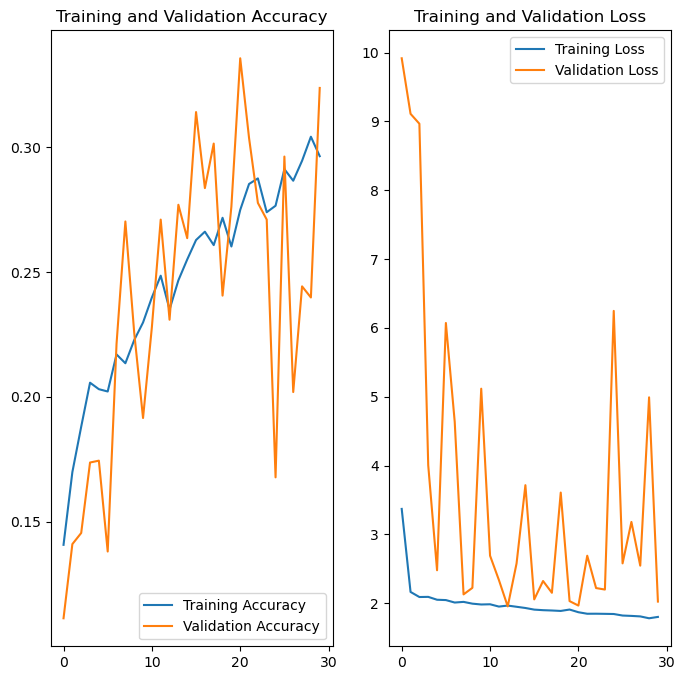

In [165]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
The accuracy didnt approve. but overfitting is handled with class rebalance